✅ Loaded emnist/byclass with 62 classes


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 62)             │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,094 (234.74 KB)

 Trainable params: 60,094 (234.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2290 - loss: 3.3638 - val_accuracy: 0.5735 - val_loss: 1.7091
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5878 - loss: 1.6072 - val_accuracy: 0.6775 - val_loss: 1.1728
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6761 - loss: 1.1372 - val_accuracy: 0.7205 - val_loss: 0.9628

✅ Test Accuracy on subset: 0.720


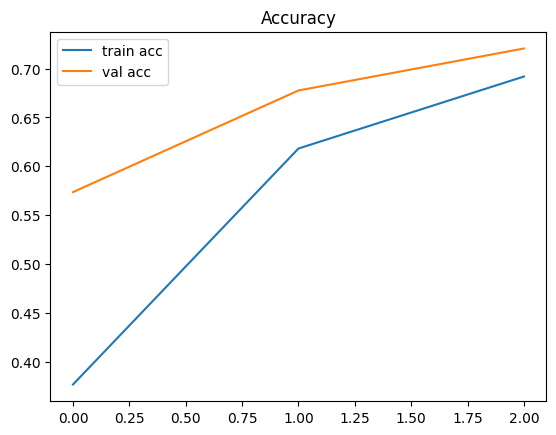

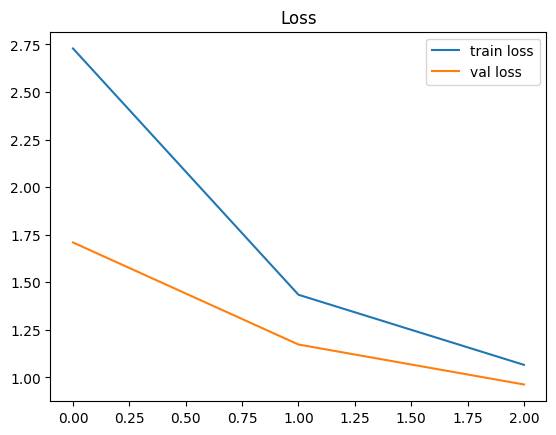


📤 Upload a handwritten image (jpg/png).


Saving handwirrten.jpg to handwirrten (4).jpg
🖊 handwirrten (4).jpg → Predicted: n (class 49)


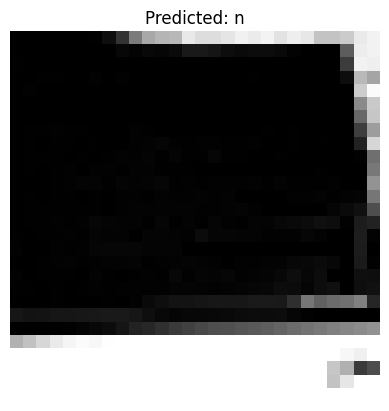

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
DATASET_VARIANT = "emnist/byclass"
TRAIN_SAMPLES   = 10000
TEST_SAMPLES    = 2000
BATCH_SIZE      = 128
EPOCHS          = 3
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    DATASET_VARIANT,
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
print(f"✅ Loaded {DATASET_VARIANT} with {num_classes} classes")
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # [0,1]
    return image, label

ds_train = (
    ds_train_raw
    .take(TRAIN_SAMPLES)
    .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(2000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_test = (
    ds_test_raw
    .take(TEST_SAMPLES)
    .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test,
    callbacks=callbacks,
    verbose=1
)
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"\n✅ Test Accuracy on subset: {test_acc:.3f}")

plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Accuracy")
plt.legend(); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss")
plt.legend(); plt.show()
from google.colab import files
print("\n📤 Upload a handwritten image (jpg/png).")
uploaded = files.upload()
emnist_labels_byclass = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
emnist_labels_letters = "abcdefghijklmnopqrstuvwxyz"

if DATASET_VARIANT.endswith("byclass"):
    CLASS_MAP = emnist_labels_byclass
else:
    CLASS_MAP = emnist_labels_letters

for fname in uploaded.keys():
    # Read grayscale
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {fname}, skipping.")
        continue
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    # Resize to 28x28
    resized = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_AREA)
    arr = resized.astype("float32") / 255.0
    arr = arr.reshape(1, 28, 28, 1)

    # Predict
    probs = model.predict(arr, verbose=0)
    pred_idx = int(np.argmax(probs))
    pred_char = CLASS_MAP[pred_idx] if pred_idx < len(CLASS_MAP) else f"#{pred_idx}"

    print(f"🖊 {fname} → Predicted: {pred_char} (class {pred_idx})")

    # Show what the model sees
    plt.imshow(resized, cmap="gray")
    plt.title(f"Predicted: {pred_char}")
    plt.axis("off")
    plt.show()


In [ ]:
# Task 4: Disease Prediction from Medical Data

# Step 1: Install dependencies (if not installed)
!pip install scikit-learn pandas

# Step 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 3: Upload CSV dataset
from google.colab import files
uploaded = files.upload()

# Load dataset (example: diabetes.csv or heart.csv)
import io
dataset = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

print("📊 Dataset Preview:")
print(dataset.head())

# Step 4: Split features & target
X = dataset.iloc[:, :-1]   # all columns except last
y = dataset.iloc[:, -1]    # last column = target (disease outcome)

# Step 5: Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Train model (Random Forest)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Step 8: Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model trained successfully! Accuracy: {acc*100:.2f}%")

# Step 9: Test custom input
print("\n🔮 Test Prediction:")
sample_input = [6,148,72,35,0,33.6,0.627,50]  # Example for diabetes dataset
sample_input = np.array(sample_input).reshape(1, -1)
sample_input = scaler.transform(sample_input)
prediction = model.predict(sample_input)[0]

if prediction == 1:
    print("⚠️ Disease Detected")
else:
    print("✅ No Disease Detected")
